In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [2]:
## Import necessary libraries
# Pytorch
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

# Torch vision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Matplot
import matplotlib.pyplot as plt

# Other libraries
import random
import numpy as np


# Set seeding function to reproduce results and  set a datapath for storing data

In [3]:
DATA_PATH = '../data/'
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Preprocessing data where we scale value of each pixel to [0:1] and calculate mean and standard deviation of 3 channels (R,G,B) for standardization
* Rescale each pixel to [0:1]
* Calculate mean and std

In [4]:
train_set = CIFAR10(root=DATA_PATH, train=True, download=True)
DATA_MEAN = (train_set.data / 255.0).mean((0,1,2)) 
DATA_STD = (train_set.data / 255.0).std((0,1,2))
DATA_MEAN, DATA_STD

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data/


(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

# Use DataLoader in pytroch for reading data from dataset
* Define the transform function to do data augmentation when reading data from dataset using DataLoader
* Divide training set to training set and validation set
* Create DataLoader for training set, validation set and test set

In [5]:
# This line of code is to auto completion of code using key "Tab". Just make coding faster ^^! 
# I read from this post "https://www.kaggle.com/getting-started/51622"
%config Completer.use_jedi = False

In [6]:
# We should not use data augmentation for test and validation set
test_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(DATA_MEAN, DATA_STD)])

# Train set should take advantage of data augmentation for creating more images
train_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEAN, DATA_STD),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1))])

# Read data with transform, validation set is also a test set in training proceduce which we should not use data augmentation
train_dataset = CIFAR10(root=DATA_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATA_PATH, train=True, transform=test_transform, download=True)
test_set = CIFAR10(root=DATA_PATH, train=False, transform=test_transform, download=True)

# Divide data in to a train and validation set with ratio train: val = 9:1
# The following lines are tricky, which we use same seeding to keep same data partition for both train and val. 
# We cannot use a single line of code "train_set, val_set = data.random_split(train_dataset, [45000, 5000])" 
# becasue val_dataset and train_dataset use different transforms
set_seed(1337)
train_set, _ = data.random_split(train_dataset, [45000, 5000])
set_seed(1337)
_, val_set = data.random_split(val_dataset, [45000, 5000])

## Define a set of data loaders that we can use for various purposes
batch_size = 128
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=8)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Image visualization
* Read images from created DataLoader
* Show images

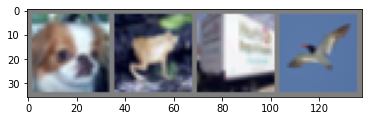

dog   frog  truck bird 


In [7]:
# Define number of images want to show
NUM_IMGS = 4

# Define classes by name for labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define a loader to read NUM_IMGS. I dont want to show images using train_loader because it loads a batch_size (128) images each time
show_loader = data.DataLoader(train_set, batch_size=NUM_IMGS, shuffle=True)

# Read images
set_seed(1337)
imgs, labels = next(iter(show_loader))

# Create a grid of images
imgs = torchvision.utils.make_grid(imgs, normalize=True, pad_value=0.5)
# Convert images to a readable numpy for plt
imgs = imgs.numpy()

# Transform imgs to an array of images
imgs = imgs.transpose((1,2,0))

# Show images
plt.imshow(imgs)
plt.show()

# Show labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(NUM_IMGS)))

# Inception layer implementation
In the following picture depicts structure of an Inception layer which is a main component of GoogLeNet. GoogLeNet composed of Inception layers stacking on top of eachother. With different kernel sizes and branches, an inception layer permits a neural network to learn different aspects of input image. Futhermore, proposed 1x1 convolution layer reduce alot of computation resource in a deep network. For explanation of 1x1 convolution layer, you can find in following video of Andrew Ng: https://www.coursera.org/lecture/convolutional-neural-networks/networks-in-networks-and-1x1-convolutions-ZTb8x
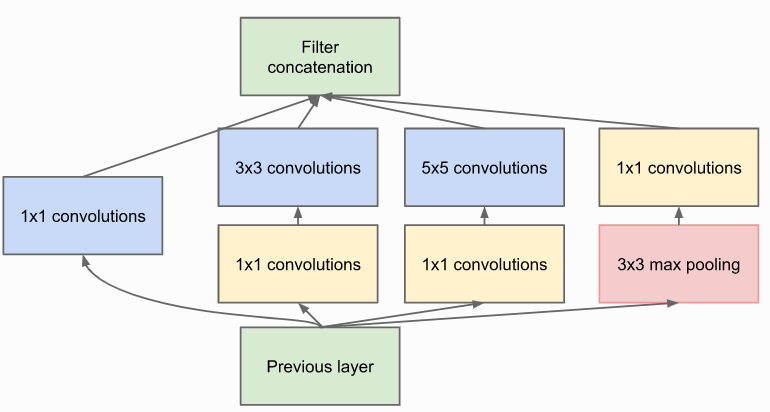

In [8]:
class InceptionBlock(nn.Module):
    def __init__(self, c_in, c_red: dict, c_out: dict):
        '''
        c_in: number of channel from previous layer
        c_red: number of 1x1 convolution layer which is passed to 3x3 and 5x5 convolution layers afterwards.
        c_out: number of channel of 4 branches
        '''
        super().__init__()
        
        # 1x1 branch
        self.conv_1x1 = nn.Sequential(nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
                                     nn.BatchNorm2d(c_out["1x1"]),
                                     nn.ReLU())
        
        # 3x3 branch, we padding 1 in the 3x3 convolution layer to keep same size of image
        self.conv_3x3 = nn.Sequential(nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
                                     nn.BatchNorm2d(c_red["3x3"]),
                                     nn.ReLU(),
                                     nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
                                     nn.BatchNorm2d(c_out["3x3"]),
                                     nn.ReLU())
        
        # 5x5 branch, we padding 2 in the 5x5 convolution layer to keep same size of image
        self.conv_5x5 = nn.Sequential(nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
                                     nn.BatchNorm2d(c_red["5x5"]),
                                     nn.ReLU(),
                                     nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
                                     nn.BatchNorm2d(c_out["5x5"]),
                                     nn.ReLU())        
        # Max pooling branch
        self.max_pool = nn.Sequential(nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
                                     nn.Conv2d(c_in, c_out["max"], kernel_size=1),
                                     nn.BatchNorm2d(c_out["max"]),
                                     nn.ReLU())
        
    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        output = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return output

# GoogLeNet
Google Net is composed of Inception layers where the architecture is proposed in this paper: "https://arxiv.org/pdf/1409.4842.pdf"
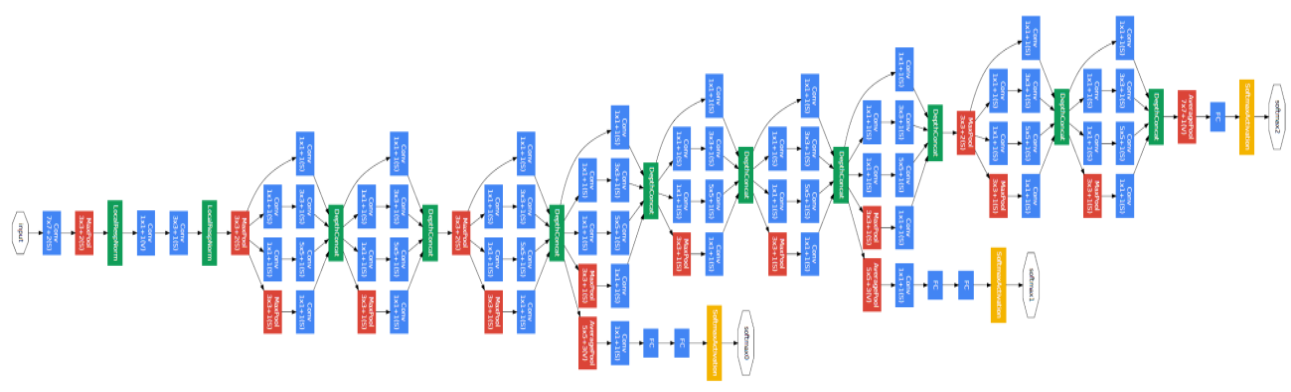

In [9]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes=10):
        '''
        num_classes: number of classes in CIFAR10 
        '''
        super().__init__()
        
        # An image containing 3 channels (R,G,B) which is fed into GoogLeNet is scaled up to 64 channels
        # In Cifar10 each image 32x32x3 -> 32x32x64
        self.input = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        
        # Stacking inception blocks
        self.inception = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16})
        )
        
        # Mapping to classification output by a fully connected layer
        self.output = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.input(x)
        x = self.inception(x)
        x = self.output(x)
        return x
googleNet = GoogleNet()

# Define a loss function and optimizer
* Loss function: CrossEntropyLoss()
* Optimizer: AdamW which is Adam with a correct implementation of weight decay (https://arxiv.org/pdf/1711.05101.pdf)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(googleNet.parameters(), 
                        lr=1e-3, 
                        weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                           milestones=[100, 150], 
                                           gamma=0.1)

# Train model

In [11]:
# Define the number of epochs
n_epochs = 200

# Use GPU if possible
googleNet.to(device)

# Training loop
for epoch in range(n_epochs + 1):
    
    running_loss = 0.0 
    total = 0
    correct = 0
    
    # Training procedure
    for data in train_loader:
        # Get the inputs, labels and put them to GPU if possible 
        inputs, labels = data[0].to(device), data[1].to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + Backward + Optimize
        outputs = googleNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Reduce learning rate by 0.1 after 100 and 150 epochs   
    scheduler.step()
    
    # Validation procedure
    with torch.no_grad():
        for data in val_loader:
            # Get the inputs, labels and put them to GPU if possible 
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = googleNet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # Display statistics
    if epoch % 10 == 9:
        print(f"Epoch: {epoch +1:3d}, loss: {running_loss/len(train_set)}, val_acc: {100 * correct / total:.2f}%")
    
    # Reset training loss
    running_loss = 0.0
    
print("Training completed!")

Epoch:  10, loss: 0.0030670265790488983, val_acc: 85.12%
Epoch:  20, loss: 0.0020090782231754725, val_acc: 87.60%
Epoch:  30, loss: 0.0014686217442154885, val_acc: 88.02%
Epoch:  40, loss: 0.0010998973515298632, val_acc: 88.96%
Epoch:  50, loss: 0.0009192738987919357, val_acc: 88.90%
Epoch:  60, loss: 0.0007591170779118935, val_acc: 89.16%
Epoch:  70, loss: 0.0006921583402901888, val_acc: 89.58%
Epoch:  80, loss: 0.0005826531219399638, val_acc: 90.14%
Epoch:  90, loss: 0.0005214315656986502, val_acc: 89.66%
Epoch: 100, loss: 0.00047273804323954714, val_acc: 90.14%
Epoch: 110, loss: 0.00013941361642856565, val_acc: 91.66%
Epoch: 120, loss: 0.00010008931412465043, val_acc: 91.32%
Epoch: 130, loss: 8.903092316403571e-05, val_acc: 91.22%
Epoch: 140, loss: 7.642338455447721e-05, val_acc: 91.68%
Epoch: 150, loss: 7.009125641715299e-05, val_acc: 91.46%
Epoch: 160, loss: 5.430075974824528e-05, val_acc: 91.72%
Epoch: 170, loss: 5.87540830563133e-05, val_acc: 91.76%
Epoch: 180, loss: 5.000093922

In [12]:
# Test model on test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = googleNet(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the GoogLeNet on the CIFAR10 test images: {100 * correct / total:.2f} %')

Accuracy of the GoogLeNet on the CIFAR10 test images: 90.69 %
